# Natural language processing

## Task 1

Загрузи датасет. Отрисуй Bar-plot с количеством комментариев для каждой категории токсичности 
и комментариев без токсичности.
![sample](../misc/images/bar-plot.png)
Выведи эти количества для каждой категории. 

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('wordnet')
#nltk.download('corpus')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.multiclass import OneVsRestClassifier

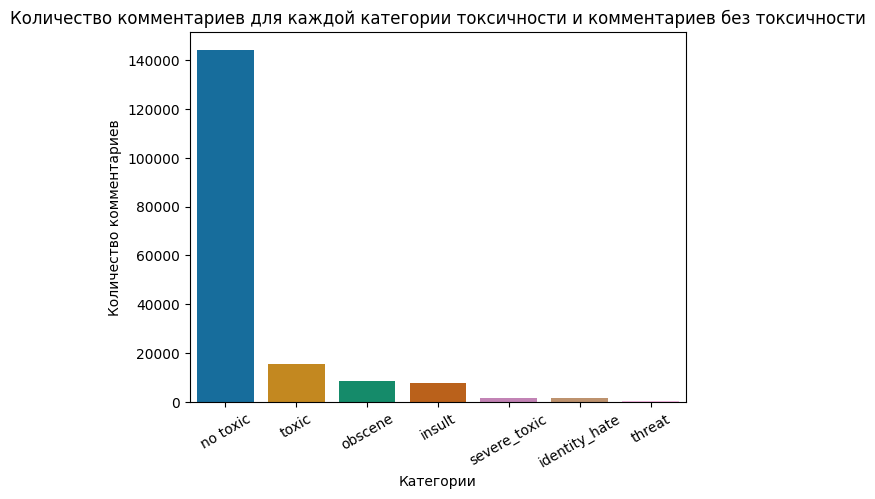

In [52]:
NLP_data = pd.read_csv('../datasets/toxic.csv')
df = pd.DataFrame({'Категории': ['no toxic', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                   'Количество комментариев': [(NLP_data['toxic']==0).sum(), (NLP_data['toxic']==1).sum(), (NLP_data['severe_toxic']==1).sum(), (NLP_data['obscene']==1).sum(), (NLP_data['threat']==1).sum(), (NLP_data['insult']==1).sum(), (NLP_data['identity_hate']==1).sum()]})
df = df.sort_values(by = 'Количество комментариев',ascending=False)
sns.barplot(x='Категории', y='Количество комментариев', data = df, palette="colorblind").set (title='Количество комментариев для каждой категории токсичности и комментариев без токсичности')
plt.xticks(rotation=30)
plt.show()
NLP_data = NLP_data.set_index('id')

## Task 2

Используя библиотеку [nltk](https://www.nltk.org/) обработайте тексты комментариев: 
* Приведи текст к нижнему регистру и токенизируй
* Оставь токены содержащие английского алфавита 
* Убери знаки препинания, цифры
* Убери стоп-слова из библиотки nltk

Выведи количество токенов для комментария с индексом `000103f0d9cfb60f`

In [53]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
def data_preprocessing(comment_text):
    comment_text = comment_text.lower() #приведение текст к нижнему регистру
    tokens = nltk.word_tokenize(comment_text)
    comment_text = [word for word in tokens if word not in stop_words and word.isalpha()]
    comment_text = [lemmatizer.lemmatize(word) for word in comment_text]
    comment_text = ' '.join(comment_text)
    return comment_text
NLP_data['preprocessed_comment_text'] = NLP_data['comment_text'].apply(lambda comment_text: data_preprocessing(comment_text))
def data_list(comment_text1):
    comment_text1 = comment_text1.lower() #приведение текст к нижнему регистру
    tokens = nltk.word_tokenize(comment_text1)
    comment_text1 = [word for word in tokens if word not in stop_words and word.isalpha()]
    comment_text1 = [lemmatizer.lemmatize(word) for word in comment_text1]
    return comment_text1
NLP_data['list_comment_text'] = NLP_data['comment_text'].apply(lambda comment_text: data_list(comment_text))
print('Токены для комментария с индексом 000103f0d9cfb60f:', NLP_data.loc["000103f0d9cfb60f"]['list_comment_text'])
print('Количество токенов для комментария с индексом 000103f0d9cfb60f:', len(NLP_data.loc["000103f0d9cfb60f"]['list_comment_text']))

Токены для комментария с индексом 000103f0d9cfb60f: ['match', 'background', 'colour', 'seemingly', 'stuck', 'thanks', 'talk', 'january', 'utc']
Количество токенов для комментария с индексом 000103f0d9cfb60f: 9


## Task 3

Раздели выборку на тренировачную и тестовоую с параметрами `random_state=21, test_size=0.3, shuffle=True`
Преобразуй тексты комментариев с помощью [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) с количеством признаков равный 3000. \
Выведи размерность тренировачной выборки после преобразования текста.

In [54]:
data = NLP_data.copy()
y = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
data.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis = 1, inplace = True)
X_train, X_test, y_train, y_test =  train_test_split(data, y, random_state=21, test_size=0.3, shuffle=True)
vectorizer = TfidfVectorizer(max_features = 3000)
X_train_comment_text_tfidf = vectorizer.fit_transform(X_train['preprocessed_comment_text'])
vectorizer.get_feature_names_out()
X_test_comment_text_tfidf = vectorizer.transform(X_test['preprocessed_comment_text'])
print(X_train_comment_text_tfidf.shape)

(111699, 3000)


## Task 4

Реши задачу [Multi-Label](https://scikit-learn.org/stable/modules/multiclass.html) классификации используя [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier).
Посчитай значение ROC-AUC для тестовой выборки.

In [55]:
clf = RidgeClassifier().fit(X_train_comment_text_tfidf, y_train)
y_pred = clf.predict(X_test_comment_text_tfidf)
rc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC=%.3f' % (rc_auc))

ROC-AUC=0.656


## Task 5

Есть посмотреть на тексты токсичных комментариев, то можно заметить, что они могут повторять одни и те же слова. Или там чаще встречается `!` знаки. \
Кроме 'прямых' текстовых признаков, можно использоваться и эту статистику по тексту. Например, долю уникальных слов в тексте комментария или количество пунктуации в тексте.

Придумай не меньше 4х признаков, которые могут помочь в обучении модели. Добавьте их к признакам TF-IDF и обучите модель. 
Получилось ли увеличить качество классификации?

In [65]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
data_copy = NLP_data.copy()
def new_processed_text(comment_text):
    tokens = nltk.word_tokenize(comment_text)
    comment_text = [word for word in tokens if word not in stop_words]
    comment_text = [lemmatizer.lemmatize(word) for word in comment_text]
    comment_text = ' '.join(comment_text)
    return comment_text
data_copy['new_processed_text'] = data_copy['comment_text'].apply(lambda comment_text: new_processed_text(comment_text))

y1 = data_copy[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
data_copy.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis = 1, inplace = True)
X_train1, X_test1, y_train1, y_test1 =  train_test_split(data_copy, y1, random_state=21, test_size=0.3, shuffle=True)

exclamation_point_train = data_copy.loc[X_train1.index]['new_processed_text'].apply(lambda x: x.count('!'))
exclamation_point_test = data_copy.loc[X_test1.index]['new_processed_text'].apply(lambda x: x.count('!'))


curse_words = set(['die', 'hell', 'fuck', 'stupid', 'cocksucker', 'piss', 'fool', 'nazi'])
curse_words_train = data_copy.loc[X_train1.index]['new_processed_text'].apply(lambda x:
                                                                                 len(set(x.lower().split()).intersection(curse_words)) /
                                                                                 len(set(x.lower().split())))
curse_words_test = data_copy.loc[X_test1.index]['new_processed_text'].apply(lambda x:
                                                                               len(set(x.lower().split()).intersection(curse_words)) /
                                                                               len(set(x.lower().split())))

censored_words_train = data_copy.loc[X_train1.index]['new_processed_text'].apply(lambda x: x.count('*'))
censored_words_test = data_copy.loc[X_test1.index]['new_processed_text'].apply(lambda x: x.count('*'))

repeated_words_train = data_copy.loc[X_train1.index]['new_processed_text'].apply(lambda x: len(x.split()) - len(set(x.split())))
repeated_words_test = data_copy.loc[X_test1.index]['new_processed_text'].apply(lambda x: len(x.split()) - len(set(x.split())))

unique_words_train = data_copy.loc[X_train1.index]['new_processed_text'].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1))
unique_words_test = data_copy.loc[X_test1.index]['new_processed_text'].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1))

additional_sign_train = csr_matrix(np.array([exclamation_point_train, curse_words_train, censored_words_train, repeated_words_train, unique_words_train]).T)
additional_sign_test = csr_matrix(np.array([exclamation_point_test, curse_words_test, censored_words_test, repeated_words_test, unique_words_test]).T)
X_train_tfidf_combin = hstack((X_train_comment_text_tfidf, additional_sign_train))
X_test_tfidf_combin = hstack((X_test_comment_text_tfidf, additional_sign_test))

model_combined = OneVsRestClassifier(RidgeClassifier())
model_combined.fit(X_train_tfidf_combin, y_train1)
y_pred1 = model_combined.predict(X_test_tfidf_combin)

roc_auc_combin = roc_auc_score(y_test1, y_pred1)
print('ROC-AUC=%.3f' % (roc_auc_combin))

ROC-AUC=0.658
